# Team Information 
- Team Number 139
- Team Members : Jae Cho : jaecho2@illinois.edu


# GitHub 

https://github.com/JCNextCode/CS598

# Youtube Presentation

https://youtu.be/MOvT7DeRfM8

# Introduction

*   Background of the problem
  * **Type of Problem** :The paper focuses on predicting readmission to the ICU within 30 days of discharge.  

  * **Importance** : Predicting ICU readmission can help improve patient outcomes and reduce healthcare cost by identifying individuals at higher risk and enabling timely interventions.

  * **Difficulty** : This is challenging due to the complexity of medical data, the need for interpretable models that can be integrated into clinical workflows, and the high dimensionality of EMR data.

  * **State of the Art Methods and Effectiveness** : The study benchmarks various deep learning models, including those utilizing attention mechanisms recurrent layers, and neural ODEs.  The effectiveless is measured by accuracy and F1-Score.

## Paper explanation

Paper Title : Benchmarking Deep Learning Architectures for Predicting Readmission to the ICU and Describing Patients-at-Risk


  * **Proposal** : Study introduces and evaluates multiple deep learning frameworks, focusing on interpretability and prediction accuracy.

  * **Innovations of the Method** : Innovations include the use of time-aware attention and neural ODEs for dynamic embeddings of medical concepts, aiming to improve the relevance and accuracy of the predictions.

  * **Effectiveness of the Proposal** : Showed competitive predictive performance, with the best models achieving an average accuracy score of 0.331,  and F1-Score of 0.375.

  * **Contribution to Research Regime** : The paper contributes significantly by comparing different architectures and offering a comprehensive study on their applicability for ICU readmission prediction.  This research aids in understanding how different models handle the complexity of EMR data and their practical utility in a clinical setting.


# Scope of Reproducibility:

### Hypothesis 1 :

Attention mechanisms improve the interpretability of ICU readmission predictions without significantly compromising the predictive accuracy.

- **Experiment**: Implement a basic Recurrent Neural Network (RNN) model and compare it with an RETAIN (Reverse Time Attention Interpreter) and Transformer that incorporates an attention mechanism.
Use PyHealth for modeling. Evaluate both models on metrics such as accuracy, and F1-Score.

<br>

### Hypothesis 2 :
Models utilizing time-aware attention mechanisms outperform traditional RNNs in handling irregular time intervals in ICU data.

- **Experiment**: Create two models, one with a traditional RNN and another with a time-aware attention mechanism. Train both on ICU readmission data with irregular time intervals. Compare their performance.


# Methodology


The pyhealth library will be used whenever possible.

Pyhealth provides a readmission function `readmission_prediction_mimic3_fn` that can make predictions based on the MIMIC-III data.

The following models from the pyhealth library will be used.
- RNN Model
- RETAIN Model
- Transformer Model
- StageNet Model
- TCN Model



In [ ]:
!pip import pyhealth

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

from pyhealth.datasets import MIMIC3Dataset
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Data
Because the entire MIMIC-III Data is quite extensive and takes a very long time to process.  I used a MIMIC-III demo data which was also available at https://physionet.org/content/mimiciii-demo/1.4/

The relevant csv files where loaded into a github repository for processing.

Tables ADMISSIONS and PATIENTS are parsed by pyhealth by default.

The additional tables that will be used are DIAGNOSES_ICD, PROCEDURES_ICD, PRESCRIPTIONS.

There are additional tables that should be parsed ICUSTAYS, SERVICES, CARTEVENTS OUTPUTEVENTS.  These however are not support by pyhealth at the moment so did not include them.


Also used code mapping to map NDC granular codes to ATC.

In [28]:
# Data Setup from raw MIMIC3

mimic3_ds = MIMIC3Dataset(
    #root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    root="https://github.com/JCNextCode/CS598/tree/main/mimic-iii-demo/",
    # Basic Tables are parsed by default MIMIC3Dataset: {'ADMISSIONS', 'PATIENTS'}
    # Parser for ICUSTAYS, SERVICES, CARTEVENTS OUTPUTEVENTS is not implemented yet.
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], 
    # mapping to ATC to make things less granular.
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    #code_mapping = {},
    #dev=True,
)

### Data Check


A data check was done to confirm the proper import and parsing of the data.

```
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PROCEDURES_ICD: 3.2186
	- Number of events per visit in PRESCRIPTIONS: 32.9969
```

In [29]:
mimic3_ds.stat()
#mimic3_ds.info()
mimic3_ds.available_tables
patient = mimic3_ds.patients
print(list(patient.keys())[:10])


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PROCEDURES_ICD: 3.2186
	- Number of events per visit in PRESCRIPTIONS: 32.9969

['1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005']


## Model  

When working on this project I tried to utilize the pyhealth library as much as possible.

After loading the data we want to calculate the readmission prediction.

Pyhealth offers a great function to make this possible.

```
readmission_prediction_mimic3_fn
```

This function predicts wheather the patient will be readmitted into the hospital within the 30 day time window.

The function will return a list of samples.  Each sample is a dictionary with PATIENT_ID, VISIT_ID and other task-specific attributes.

I will also use a precision list to append all the comparisons.  This is for the comparison reporting.

In [30]:
from pyhealth.tasks import readmission_prediction_mimic3_fn

mimic_sample = mimic3_ds.set_task(readmission_prediction_mimic3_fn)

precision_report = []
accuracy_report = []

Generating samples for readmission_prediction_mimic3_fn: 100%|██████████| 49993/49993 [00:04<00:00, 10414.78it/s]


In [31]:
mimic_sample.samples[0]

{'visit_id': '110342',
 'patient_id': '10009',
 'conditions': [['5789', '2724', '45620', '78659', '45981', '81601', '5848']],
 'procedures': [['4516']],
 'drugs': [['A02B', 'N02A', 'B01A', 'A04A', 'A12B', 'A06A', 'N06A']],
 'label': 0}

### Basic RNN Model 

We will start with basic RNN which are suitable for healthcare datasets like MIMIC-III because they can model temporal dependencies in data.  

By setting up RNN with specific parameters, we prepare the model to lean from the specific features of the MIMIC-III dataset related to patient conditions and procedures, with the goal of predicting a binary outcome based on the historical sequence.


Loss reduction started to diminish at around 40 epochs so will use this going forward.


The forward function will return:
- loss : a scalar tensor representing the loss.
- y_prob: a tensor representing the predicted probabilities.
- y_true: a tensor representing true labels

In [32]:
from pyhealth.models import RNN

model_RNN = RNN(
    dataset=mimic_sample,
    # get this from mimic_sample.samples[0]
    feature_keys=["conditions","procedures"],
    label_key = "label",
    mode="binary",
)

### RNN Model Training

Initially started out with 40 epochs after evaluation of the graph determined that 40 epochs are required to accurately run RNN Model.

In [9]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer

from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.multiclass import multiclass_metrics_fn



precision_report = []
accuracy_report = []


train_ds, val_ds, test_ds = split_by_patient(mimic_sample, [0.8,0.1,0.1])

#create data loaders
train_loader = get_dataloader(train_ds, batch_size = 32, shuffle= True)
val_loader = get_dataloader(val_ds, batch_size = 32, shuffle= False)
test_loader = get_dataloader(test_ds, batch_size = 32, shuffle= False)



class CustomTrainer(Trainer):
    def __init__(self, model):
        super().__init__(model=model)
        self.epoch_metrics = []

    def train(self, t_dataloader, v_dataloader, epochs):
        for epoch in range(epochs):
            super().train(train_dataloader=t_dataloader, val_dataloader=v_dataloader, epochs = 1) 
            metrics = self.evaluate(t_dataloader)
            metrics['epoch'] = epoch
            self.epoch_metrics.append(metrics)
    

trainer = CustomTrainer(model=model_RNN)
trainer.train(
    t_dataloader = train_loader,
    v_dataloader = val_loader,
    epochs = 40,
) 


y_true, y_prob, loss = trainer.inference(test_loader)
precision_report.append(binary_metrics_fn(y_true, y_prob, metrics=["precision","roc_auc","f1"]))
accuracy_report.append(multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy","f1_weighted","roc_auc_weighted_ovo"]))


#print(precision_report)
#print(accuracy_report)

RNN(
  (embeddings): ModuleDict(
    (conditions): Embedding(2526, 128, padding_idx=0)
    (procedures): Embedding(815, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (rnn): ModuleDict(
    (conditions): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
    (procedures): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Metrics: None
Device: cpu

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1


/Users/jaecho/Desktop/SourceCode/DATA_SCIENCE/CS598/pyhealth/trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.92it/s]

--- Train epoch-0, step-55 ---
loss: 0.4574



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 141.87it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1619
roc_auc: 0.5147
f1: 0.0000
loss: 0.5203



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 85.56it/s] 

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:03<00:00, 15.55it/s]

--- Train epoch-0, step-55 ---
loss: 0.3743



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 41.34it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1539
roc_auc: 0.4851
f1: 0.0000
loss: 0.5008



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 70.66it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 11.67it/s]

--- Train epoch-0, step-55 ---
loss: 0.3510



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 30.90it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1468
roc_auc: 0.4564
f1: 0.0000
loss: 0.5212



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 36.70it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.77it/s]

--- Train epoch-0, step-55 ---
loss: 0.3405



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 36.22it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1394


roc_auc: 0.4186
f1: 0.0000
loss: 0.5232


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 53.06it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00,  9.21it/s]

--- Train epoch-0, step-55 ---
loss: 0.3275



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 28.36it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1378
roc_auc: 0.4004
f1: 0.0000
loss: 0.5255



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 32.48it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 11.20it/s]

--- Train epoch-0, step-55 ---
loss: 0.3112



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 85.13it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1345
roc_auc: 0.4001
f1: 0.0000
loss: 0.5338



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 56.31it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.16it/s]

--- Train epoch-0, step-55 ---
loss: 0.3069



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 31.71it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1316
roc_auc: 0.3980
f1: 0.0000
loss: 0.5702



Evaluation: 100%|██████████| 55/55 [00:04<00:00, 11.43it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:15<00:00,  3.56it/s]

--- Train epoch-0, step-55 ---
loss: 0.2934



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 39.18it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1353
roc_auc: 0.4048


f1: 0.0000
loss: 0.5491


Evaluation: 100%|██████████| 55/55 [00:00<00:00, 69.96it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 12.40it/s]

--- Train epoch-0, step-55 ---
loss: 0.2663



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 44.50it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1366
roc_auc: 0.4127
f1: 0.0000
loss: 0.5880



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 50.67it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.49it/s]

--- Train epoch-0, step-55 ---
loss: 0.2597



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 40.46it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1377


roc_auc: 0.4199
f1: 0.0000
loss: 0.5987


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 34.87it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.23it/s]

--- Train epoch-0, step-55 ---
loss: 0.2535



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 41.77it/s]


--- Eval epoch-0, step-55 ---
pr_auc: 0.1414
roc_auc: 0.4218
f1: 0.0000
loss: 0.6026


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 42.19it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00,  9.21it/s]

--- Train epoch-0, step-55 ---
loss: 0.2351



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 67.44it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1411
roc_auc: 0.4191
f1: 0.0000
loss: 0.6393



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 40.46it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:11<00:00,  4.77it/s]

--- Train epoch-0, step-55 ---
loss: 0.2158



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 17.03it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1423
roc_auc: 0.4215
f1: 0.0000
loss: 0.6504



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 17.43it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:11<00:00,  4.94it/s]

--- Train epoch-0, step-55 ---
loss: 0.2200



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1378
roc_auc: 0.4159
f1: 0.0000
loss: 0.6583



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 21.32it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:12<00:00,  4.46it/s]

--- Train epoch-0, step-55 ---
loss: 0.2175



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.01it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1369
roc_auc: 0.4139
f1: 0.0000
loss: 0.6711



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 21.68it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.81it/s]

--- Train epoch-0, step-55 ---
loss: 0.1959



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 44.89it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1411
roc_auc: 0.4211
f1: 0.0000


loss: 0.6805


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 46.92it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.52it/s]

--- Train epoch-0, step-55 ---
loss: 0.1927



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.91it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1411
roc_auc: 0.4200
f1: 0.0000
loss: 0.7104



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 18.72it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:11<00:00,  4.81it/s]

--- Train epoch-0, step-55 ---
loss: 0.1880



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 82.30it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1411
roc_auc: 0.4230
f1: 0.0000
loss: 0.7008



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 17.97it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]

--- Train epoch-0, step-55 ---
loss: 0.1636



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1508
roc_auc: 0.4435
f1: 0.0000
loss: 0.7086



Evaluation: 100%|██████████| 55/55 [00:06<00:00,  8.08it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]

--- Train epoch-0, step-55 ---


loss: 0.1627


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 38.48it/s]

--- Eval epoch-0, step-55 ---


pr_auc: 0.1470
roc_auc: 0.4359
f1: 0.0000
loss: 0.7233


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 44.63it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 13.68it/s]

--- Train epoch-0, step-55 ---


loss: 0.1543


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 77.74it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1609
roc_auc: 0.4592
f1: 0.0000
loss: 0.7550



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 62.01it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 13.68it/s]

--- Train epoch-0, step-55 ---
loss: 0.1370



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 44.64it/s]

--- Eval epoch-0, step-55 ---


pr_auc: 0.1627
roc_auc: 0.4491
f1: 0.0488
loss: 0.7747


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 54.02it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:16<00:00,  3.42it/s]

--- Train epoch-0, step-55 ---
loss: 0.1290



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 71.72it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1650
roc_auc: 0.4637
f1: 0.0488
loss: 0.7920



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 29.34it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.23it/s]

--- Train epoch-0, step-55 ---
loss: 0.1310



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 17.09it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1704
roc_auc: 0.4545
f1: 0.0909
loss: 0.7942



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 21.53it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]

--- Train epoch-0, step-55 ---
loss: 0.1173



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1587
roc_auc: 0.4534
f1: 0.0455
loss: 0.8414



Evaluation: 100%|██████████| 55/55 [00:04<00:00, 11.70it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:20<00:00,  2.71it/s]

--- Train epoch-0, step-55 ---
loss: 0.1186



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1774
roc_auc: 0.4625
f1: 0.0455
loss: 0.8625



Evaluation: 100%|██████████| 55/55 [00:05<00:00,  9.29it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:21<00:00,  2.51it/s]

--- Train epoch-0, step-55 ---
loss: 0.1012



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1781
roc_auc: 0.4625
f1: 0.0909
loss: 0.8817



Evaluation: 100%|██████████| 55/55 [00:06<00:00,  7.89it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None


Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:22<00:00,  2.41it/s]

--- Train epoch-0, step-55 ---
loss: 0.0989



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1607
roc_auc: 0.4373
f1: 0.0476
loss: 0.9964



Evaluation: 100%|██████████| 55/55 [00:06<00:00,  8.31it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]

--- Train epoch-0, step-55 ---
loss: 0.0891



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 57.24it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1671
roc_auc: 0.4406
f1: 0.0870
loss: 0.9725



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 70.47it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.74it/s]

--- Train epoch-0, step-55 ---
loss: 0.0936



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1724
roc_auc: 0.4537
f1: 0.1277
loss: 0.9287



Evaluation: 100%|██████████| 55/55 [00:06<00:00,  9.08it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:12<00:00,  4.37it/s]

--- Train epoch-0, step-55 ---
loss: 0.0814



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.21it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1996
roc_auc: 0.4525
f1: 0.0909
loss: 0.9447



Evaluation: 100%|██████████| 55/55 [00:06<00:00,  9.09it/s]

Training:
Batch size: 32


Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:15<00:00,  3.56it/s]

--- Train epoch-0, step-55 ---
loss: 0.0814



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 18.21it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1624
roc_auc: 0.4467


f1: 0.0488
loss: 1.0262


Evaluation: 100%|██████████| 55/55 [00:05<00:00,  9.22it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]

--- Train epoch-0, step-55 ---
loss: 0.0861



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1899
roc_auc: 0.4455
f1: 0.0930
loss: 0.9828



Evaluation: 100%|██████████| 55/55 [00:04<00:00, 13.25it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.28it/s]

--- Train epoch-0, step-55 ---
loss: 0.0741



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 40.54it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1881
roc_auc: 0.4387
f1: 0.0930
loss: 1.0209



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 24.74it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.45it/s]

--- Train epoch-0, step-55 ---
loss: 0.0777



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 18.68it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1974
roc_auc: 0.4429
f1: 0.0909
loss: 0.9919



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 21.44it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:09<00:00,  5.76it/s]

--- Train epoch-0, step-55 ---
loss: 0.0696



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 134.74it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1974
roc_auc: 0.4504
f1: 0.0889
loss: 1.0261



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 27.09it/s]

Training:


Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.02it/s]

--- Train epoch-0, step-55 ---
loss: 0.0683



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 21.25it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1897


roc_auc: 0.4472
f1: 0.0930
loss: 1.0947


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 27.75it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.02it/s]

--- Train epoch-0, step-55 ---
loss: 0.0606



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 21.66it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1829
roc_auc: 0.4548
f1: 0.0952
loss: 1.1077



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 22.64it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]

--- Train epoch-0, step-55 ---
loss: 0.0629



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.07it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1766
roc_auc: 0.4598
f1: 0.0889
loss: 1.1018



Evaluation: 100%|██████████| 55/55 [00:05<00:00, 10.68it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c5c0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:21<00:00,  2.60it/s]

--- Train epoch-0, step-55 ---
loss: 0.0549



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.02it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1762
roc_auc: 0.4379
f1: 0.0909
loss: 1.1405



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 19.20it/s]


### RNN Model Evaluation

Graph shows 40 epchos are required to flatline the loss.

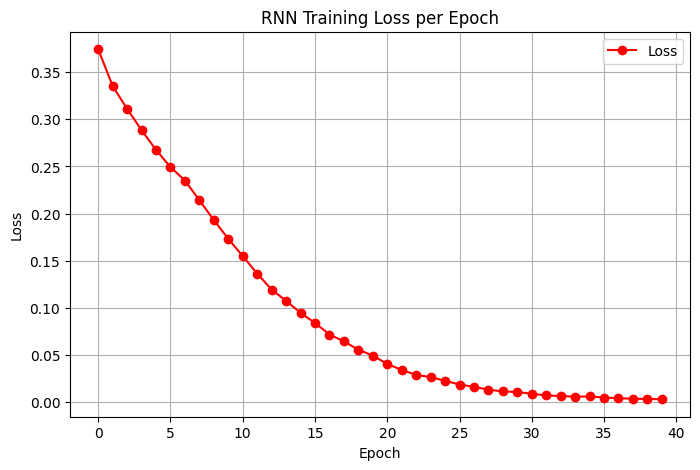

In [10]:
import matplotlib.pyplot as plt
epochs = [metric['epoch'] for metric in trainer.epoch_metrics]
losses = [metric['loss'] for metric in trainer.epoch_metrics if 'loss' in metric]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label='Loss', marker='o', color='r')
plt.title('RNN Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### RETAIN Model

RETAIN (Reverse Time Attention Model) is a type of neural network specifically designed for interpretability in electronic health record data.

It utilizes a two-level neural attention mechanism that operates in reverse time order to make it easier to understand the influence of past events on the present prediction.

RETAIN is particularly suited for tasks where understanding the rationale behind predictions is crucial.

The forward function in the class will return the loss, y_prob, y_true just as in RNN Model

In [11]:
from pyhealth.models import RETAIN

model_RETAIN = RETAIN(
    dataset=mimic_sample,
    # get this from mimic_sample.samples[0]
    feature_keys=["conditions","procedures"],
    label_key = "label",
    mode="binary",
)


### RETAIN Model Training

Initially started out with 40 epochs after evaluation of the graph determined that 25 epochs are required to accurately run RETAIN Model.

In [12]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer

from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.multiclass import multiclass_metrics_fn



train_ds, val_ds, test_ds = split_by_patient(mimic_sample, [0.8,0.1,0.1])

#create data loaders
train_loader = get_dataloader(train_ds, batch_size = 32, shuffle= True)
val_loader = get_dataloader(val_ds, batch_size = 32, shuffle= False)
test_loader = get_dataloader(test_ds, batch_size = 32, shuffle= False)



class CustomTrainer(Trainer):
    def __init__(self, model):
        super().__init__(model=model)
        self.epoch_metrics = []

    def train(self, t_dataloader, v_dataloader, epochs):
        for epoch in range(epochs):
            super().train(train_dataloader=t_dataloader, val_dataloader=v_dataloader, epochs = 1) 
            metrics = self.evaluate(t_dataloader)
            metrics['epoch'] = epoch
            self.epoch_metrics.append(metrics)
    

trainer = CustomTrainer(model=model_RETAIN)
trainer.train(
    t_dataloader = train_loader,
    v_dataloader = val_loader,
    epochs = 25,
) 

print(trainer.evaluate(train_loader))


y_true, y_prob, loss = trainer.inference(test_loader)
precision_report.append(binary_metrics_fn(y_true, y_prob, metrics=["precision","roc_auc","f1"]))
accuracy_report.append(multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy","f1_weighted","roc_auc_weighted_ovo"]))


# print(precision_report)
# print(accuracy_report)

RETAIN(
  (embeddings): ModuleDict(
    (conditions): Embedding(2526, 128, padding_idx=0)
    (procedures): Embedding(815, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (retain): ModuleDict(
    (conditions): RETAINLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (alpha_gru): GRU(128, 128, batch_first=True)
      (beta_gru): GRU(128, 128, batch_first=True)
      (alpha_li): Linear(in_features=128, out_features=1, bias=True)
      (beta_li): Linear(in_features=128, out_features=128, bias=True)
    )
    (procedures): RETAINLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (alpha_gru): GRU(128, 128, batch_first=True)
      (beta_gru): GRU(128, 128, batch_first=True)
      (alpha_li): Linear(in_features=128, out_features=1, bias=True)
      (beta_li): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Metrics: None
Device: cpu

Training:
Batch size: 32
Optimizer: <class 't

Epoch 0 / 1: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]

--- Train epoch-0, step-55 ---
loss: 0.4870



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 28.01it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2134
roc_auc: 0.6434
f1: 0.0000
loss: 0.4060



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 31.08it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.43it/s]

--- Train epoch-0, step-55 ---
loss: 0.3915



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 54.53it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1922
roc_auc: 0.6202
f1: 0.0000


loss: 0.4073


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 44.66it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:11<00:00,  4.77it/s]

--- Train epoch-0, step-55 ---
loss: 0.3442



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 41.55it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1813
roc_auc: 0.5964
f1: 0.0000
loss: 0.4152



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 26.95it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.86it/s]

--- Train epoch-0, step-55 ---
loss: 0.3018



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 79.07it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1918
roc_auc: 0.5877
f1: 0.0000
loss: 0.4249



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 52.68it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.81it/s]

--- Train epoch-0, step-55 ---
loss: 0.2798



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 70.68it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2057
roc_auc: 0.6030
f1: 0.0000
loss: 0.4193



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 17.10it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]

--- Train epoch-0, step-55 ---
loss: 0.2480



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.60it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2162
roc_auc: 0.6383
f1: 0.0000
loss: 0.4152



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 14.80it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]

--- Train epoch-0, step-55 ---
loss: 0.2177



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.14it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2109
roc_auc: 0.6306
f1: 0.0000
loss: 0.4243



Evaluation: 100%|██████████| 55/55 [00:07<00:00,  7.55it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None


Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:24<00:00,  2.26it/s]

--- Train epoch-0, step-55 ---
loss: 0.1949



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 18.07it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2010
roc_auc: 0.6322
f1: 0.0000
loss: 0.4334



Evaluation: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max


Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:24<00:00,  2.26it/s]

--- Train epoch-0, step-55 ---
loss: 0.1725



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 62.01it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2014
roc_auc: 0.6150
f1: 0.0488
loss: 0.4675



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 43.93it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0


Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.32it/s]

--- Train epoch-0, step-55 ---
loss: 0.1696



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 38.50it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2144
roc_auc: 0.6321


f1: 0.0488
loss: 0.4632


Evaluation: 100%|██████████| 55/55 [00:02<00:00, 20.07it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:15<00:00,  3.62it/s]

--- Train epoch-0, step-55 ---
loss: 0.1308



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 30.46it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2226
roc_auc: 0.6398
f1: 0.1333
loss: 0.4689



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 15.51it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:21<00:00,  2.52it/s]

--- Train epoch-0, step-55 ---
loss: 0.1289



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2175
roc_auc: 0.6317
f1: 0.1818
loss: 0.4910



Evaluation: 100%|██████████| 55/55 [00:04<00:00, 12.82it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.38it/s]

--- Train epoch-0, step-55 ---
loss: 0.1198



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 37.68it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2287


roc_auc: 0.6072
f1: 0.1905
loss: 0.5088


Evaluation: 100%|██████████| 55/55 [00:02<00:00, 24.45it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:15<00:00,  3.61it/s]

--- Train epoch-0, step-55 ---
loss: 0.1225



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 26.21it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2179
roc_auc: 0.6169
f1: 0.1429
loss: 0.5147



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 15.09it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.17it/s]

--- Train epoch-0, step-55 ---
loss: 0.1048



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 85.54it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2019
roc_auc: 0.6086
f1: 0.1333
loss: 0.5309



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 39.04it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.24it/s]

--- Train epoch-0, step-55 ---
loss: 0.0847



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 17.92it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2260
roc_auc: 0.6444
f1: 0.0930
loss: 0.5229



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 15.08it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:16<00:00,  3.34it/s]

--- Train epoch-0, step-55 ---
loss: 0.0945



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.56it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2095
roc_auc: 0.6168
f1: 0.0952
loss: 0.5556



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 17.77it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:15<00:00,  3.57it/s]

--- Train epoch-0, step-55 ---
loss: 0.0856



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 26.88it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2185
roc_auc: 0.6188
f1: 0.0976
loss: 0.5544



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 19.77it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:10<00:00,  5.22it/s]

--- Train epoch-0, step-55 ---
loss: 0.0823



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 31.54it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2084
roc_auc: 0.6296
f1: 0.0455
loss: 0.5393



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 24.98it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None


Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.32it/s]

--- Train epoch-0, step-55 ---
loss: 0.0654



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 30.40it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1957
roc_auc: 0.6031
f1: 0.0889
loss: 0.5802



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 20.51it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:12<00:00,  4.42it/s]

--- Train epoch-0, step-55 ---
loss: 0.0696



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 18.70it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2087
roc_auc: 0.5929
f1: 0.0476
loss: 0.6532



Evaluation: 100%|██████████| 55/55 [00:03<00:00, 16.51it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.62it/s]

--- Train epoch-0, step-55 ---
loss: 0.0672



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2152
roc_auc: 0.6133
f1: 0.1277
loss: 0.5985



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 29.53it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]

--- Train epoch-0, step-55 ---
loss: 0.0673



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 19.47it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2091
roc_auc: 0.6109
f1: 0.0909
loss: 0.6171



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 27.95it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:11<00:00,  4.74it/s]

--- Train epoch-0, step-55 ---
loss: 0.0554



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 20.02it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2447
roc_auc: 0.6294
f1: 0.1429
loss: 0.6268



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 35.15it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34dd0c7d0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.84it/s]


--- Train epoch-0, step-55 ---
loss: 0.0409


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 48.76it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2178
roc_auc: 0.6201
f1: 0.1395
loss: 0.6644



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 39.46it/s]


{'pr_auc': 1.0, 'roc_auc': 1.0, 'f1': 1.0, 'loss': 0.003048774867784232}


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 49.79it/s]


### RETAIN Model Evaluation

For RETAIN study shows 25 epochs are adequate.

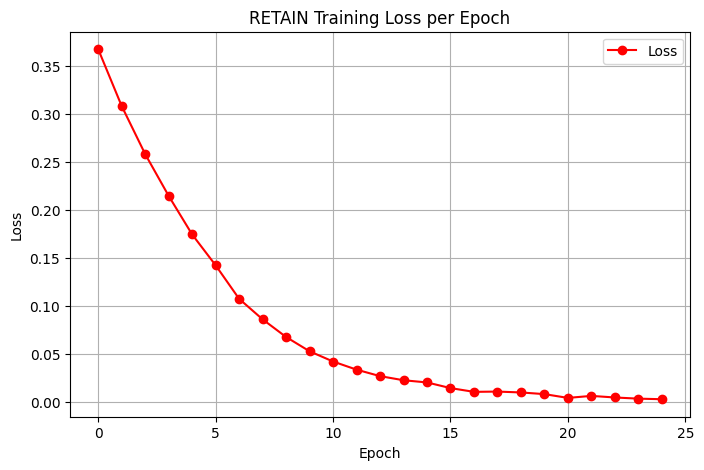

In [13]:
import matplotlib.pyplot as plt
epochs = [metric['epoch'] for metric in trainer.epoch_metrics]
losses = [metric['loss'] for metric in trainer.epoch_metrics if 'loss' in metric]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label='Loss', marker='o', color='r')
plt.title('RETAIN Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Transformer Model

Uses attention to focus more on critical parts of a patient’s medical history (e.g., previous diagnoses or vital signs) that are more relevant for predicting future medical events or outcomes.

Applies separate transformer layer for each feature, then concatenated hidden states are fed into a fully connected layer.

We initally set the attention head to the default 1 to observe the results.

The forward function in the class will return the loss, y_prob, y_true just as in RNN Model

In [14]:
from pyhealth.models import Transformer

model_Transformer = Transformer(
    dataset=mimic_sample,
    # get this from mimic_sample.samples[0]
    feature_keys=["conditions","procedures"],
    label_key = "label",
    mode="binary",
)

### Transformer Model Training

Initially started out with 40 epochs after evaluation of the graph determined that 15 epochs are required to accurately run Transformer Model.

In [15]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer

from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.multiclass import multiclass_metrics_fn



train_ds, val_ds, test_ds = split_by_patient(mimic_sample, [0.8,0.1,0.1])

#create data loaders
train_loader = get_dataloader(train_ds, batch_size = 32, shuffle= True)
val_loader = get_dataloader(val_ds, batch_size = 32, shuffle= False)
test_loader = get_dataloader(test_ds, batch_size = 32, shuffle= False)



class CustomTrainer(Trainer):
    def __init__(self, model):
        super().__init__(model=model)
        self.epoch_metrics = []

    def train(self, t_dataloader, v_dataloader, epochs):
        for epoch in range(epochs):
            super().train(train_dataloader=t_dataloader, val_dataloader=v_dataloader, epochs = 1) 
            metrics = self.evaluate(t_dataloader)
            metrics['epoch'] = epoch
            self.epoch_metrics.append(metrics)
    

trainer = CustomTrainer(model=model_Transformer)
trainer.train(
    t_dataloader = train_loader,
    v_dataloader = val_loader,
    epochs = 15,
) 

y_true, y_prob, loss = trainer.inference(test_loader)
precision_report.append(binary_metrics_fn(y_true, y_prob, metrics=["precision","roc_auc","f1"]))
accuracy_report.append(multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy","f1_weighted","roc_auc_weighted_ovo"]))


# print(precision_report)
# print(accuracy_report)

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(2526, 128, padding_idx=0)
    (procedures): Embedding(815, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (i

Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.55it/s]

--- Train epoch-0, step-55 ---
loss: 0.5819



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 89.10it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1920
roc_auc: 0.6035
f1: 0.0000
loss: 0.4079



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 53.82it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1


Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.66it/s]

--- Train epoch-0, step-55 ---
loss: 0.4750



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 43.74it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1858
roc_auc: 0.5893
f1: 0.0000
loss: 0.4047



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 32.56it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.61it/s]

--- Train epoch-0, step-55 ---
loss: 0.4097



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 149.37it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2078


roc_auc: 0.6087
f1: 0.0000
loss: 0.4198


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 47.12it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}


Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00,  9.69it/s]

--- Train epoch-0, step-55 ---
loss: 0.3650



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 27.82it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1753
roc_auc: 0.5484
f1: 0.0000
loss: 0.4485



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 37.73it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1


Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.79it/s]

--- Train epoch-0, step-55 ---
loss: 0.3296



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 30.08it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1847
roc_auc: 0.5234
f1: 0.0000
loss: 0.4494



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 44.95it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:06<00:00,  8.84it/s]

--- Train epoch-0, step-55 ---
loss: 0.3019



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 27.38it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2420
roc_auc: 0.5210
f1: 0.1333
loss: 0.5009



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 36.23it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:07<00:00,  7.32it/s]

--- Train epoch-0, step-55 ---
loss: 0.2589



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 29.07it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2338
roc_auc: 0.5117
f1: 0.1714
loss: 0.5457



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 31.10it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.67it/s]

--- Train epoch-0, step-55 ---
loss: 0.2046



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 23.55it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2010


roc_auc: 0.4941
f1: 0.2000
loss: 0.6053


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 45.70it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00,  9.21it/s]

--- Train epoch-0, step-55 ---
loss: 0.1717



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 37.24it/s]

--- Eval epoch-0, step-55 ---


pr_auc: 0.1802
roc_auc: 0.5018
f1: 0.1622
loss: 0.7344


Evaluation: 100%|██████████| 55/55 [00:01<00:00, 42.57it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00,  9.27it/s]

--- Train epoch-0, step-55 ---
loss: 0.1502



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 24.37it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2173
roc_auc: 0.5162
f1: 0.1538
loss: 0.7988



Evaluation: 100%|██████████| 55/55 [00:01<00:00, 47.28it/s]

Training:
Batch size: 32


Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

--- Train epoch-0, step-55 ---
loss: 0.1102



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.60it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1928
roc_auc: 0.5208
f1: 0.1667
loss: 1.0324



Evaluation: 100%|██████████| 55/55 [00:02<00:00, 19.55it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:08<00:00,  6.19it/s]

--- Train epoch-0, step-55 ---
loss: 0.0788



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 50.76it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.2342
roc_auc: 0.4788
f1: 0.2553
loss: 1.1402



Evaluation: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 11.33it/s]

--- Train epoch-0, step-55 ---
loss: 0.0574



Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1831
roc_auc: 0.4825
f1: 0.1739
loss: 1.4165



Evaluation: 100%|██████████| 55/55 [00:07<00:00,  7.23it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:04<00:00, 12.53it/s]

--- Train epoch-0, step-55 ---
loss: 0.0521



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 83.83it/s]

--- Eval epoch-0, step-55 ---


pr_auc: 0.1817
roc_auc: 0.5007
f1: 0.2174
loss: 1.4227


Evaluation: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e59ec60>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:05<00:00, 10.90it/s]

--- Train epoch-0, step-55 ---
loss: 0.0360



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 110.62it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1628
roc_auc: 0.4984
f1: 0.1364
loss: 1.6746



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 80.28it/s]


### Transformer Model Evaluation

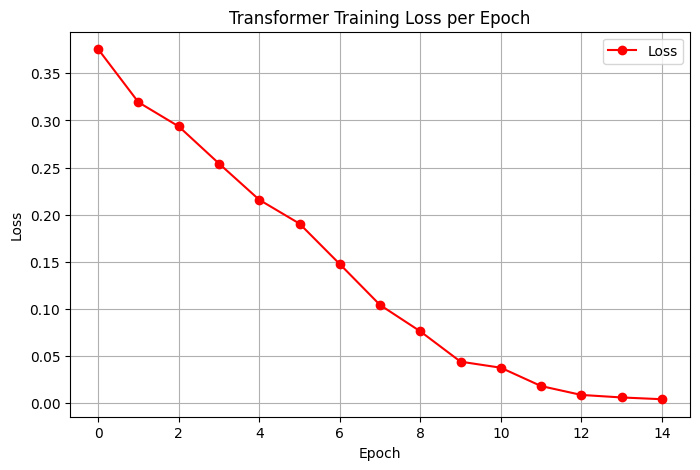

In [16]:
epochs = [metric['epoch'] for metric in trainer.epoch_metrics]
losses = [metric['loss'] for metric in trainer.epoch_metrics if 'loss' in metric]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label='Loss', marker='o', color='r')
plt.title('Transformer Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### StageNet Model

It captures complex relationships in healthcare data across different stages of patient care. 

The core idea behind StageNet includes the use of a hierarchical architecture to model different temporal scales of clinical events, which can be crucial for understanding patient trajectories and outcomes.

StageNet is designed to be particularly effective for tasks where understanding the evolution and pattern of clinical events over time is crucial.

The forward function in the class will return the loss, y_prob, y_true just as in RNN Model

In [17]:
from pyhealth.models import StageNet

model_StageNet = StageNet(
    dataset=mimic_sample,
    # get this from mimic_sample.samples[0]
    feature_keys=["conditions","procedures"],
    label_key = "label",
    mode="binary",
)

### StageNet Model Training

Initially started out with 40 epochs after evaluation of the graph determined that 6 epochs are required to accurately run Transformer Model.

In [18]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer

from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.multiclass import multiclass_metrics_fn



train_ds, val_ds, test_ds = split_by_patient(mimic_sample, [0.8,0.1,0.1])

#create data loaders
train_loader = get_dataloader(train_ds, batch_size = 32, shuffle= True)
val_loader = get_dataloader(val_ds, batch_size = 32, shuffle= False)
test_loader = get_dataloader(test_ds, batch_size = 32, shuffle= False)



class CustomTrainer(Trainer):
    def __init__(self, model):
        super().__init__(model=model)
        self.epoch_metrics = []

    def train(self, t_dataloader, v_dataloader, epochs):
        for epoch in range(epochs):
            super().train(train_dataloader=t_dataloader, val_dataloader=v_dataloader, epochs = 1) 
            metrics = self.evaluate(t_dataloader)
            metrics['epoch'] = epoch
            self.epoch_metrics.append(metrics)
    

trainer = CustomTrainer(model=model_StageNet)
trainer.train(
    t_dataloader = train_loader,
    v_dataloader = val_loader,
    epochs = 40,
) 


y_true, y_prob, loss = trainer.inference(test_loader)
precision_report.append(binary_metrics_fn(y_true, y_prob, metrics=["precision","roc_auc","f1"]))
accuracy_report.append(multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy","f1_weighted","roc_auc_weighted_ovo"]))


#print(precision_report)
#print(accuracy_report)

StageNet(
  (embeddings): ModuleDict(
    (conditions): Embedding(2526, 128, padding_idx=0)
    (procedures): Embedding(815, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (stagenet): ModuleDict(
    (conditions): StageNetLayer(
      (kernel): Linear(in_features=129, out_features=1542, bias=True)
      (recurrent_kernel): Linear(in_features=385, out_features=1542, bias=True)
      (nn_scale): Linear(in_features=384, out_features=64, bias=True)
      (nn_rescale): Linear(in_features=64, out_features=384, bias=True)
      (nn_conv): Conv1d(384, 384, kernel_size=(10,), stride=(1,))
      (nn_dropconnect): Dropout(p=0.3, inplace=False)
      (nn_dropconnect_r): Dropout(p=0.3, inplace=False)
      (nn_dropout): Dropout(p=0.3, inplace=False)
      (nn_dropres): Dropout(p=0.3, inplace=False)
    )
    (procedures): StageNetLayer(
      (kernel): Linear(in_features=129, out_features=1542, bias=True)
      (recurrent_kernel): Linear(in_features=385, out_features=1542, bias=True)
   

Epoch 0 / 1: 100%|██████████| 55/55 [00:43<00:00,  1.25it/s]

--- Train epoch-0, step-55 ---
loss: 0.4538



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1202
roc_auc: 0.5387
f1: 0.0000
loss: 0.3674



Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.35it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]

--- Train epoch-0, step-55 ---
loss: 0.3617



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1117
roc_auc: 0.5314
f1: 0.0000
loss: 0.3592



Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.41it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:33<00:00,  1.64it/s]

--- Train epoch-0, step-55 ---
loss: 0.3190



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1097
roc_auc: 0.5169
f1: 0.0000
loss: 0.3783



Evaluation: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:35<00:00,  1.55it/s]

--- Train epoch-0, step-55 ---
loss: 0.2684



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


--- Eval epoch-0, step-55 ---
pr_auc: 0.1081
roc_auc: 0.4951
f1: 0.0000
loss: 0.4550


Evaluation: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]

--- Train epoch-0, step-55 ---
loss: 0.1980



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1102
roc_auc: 0.4976
f1: 0.0000
loss: 0.5284



Evaluation: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]

--- Train epoch-0, step-55 ---
loss: 0.1134



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


--- Eval epoch-0, step-55 ---
pr_auc: 0.1034
roc_auc: 0.4603
f1: 0.0000
loss: 0.8089


Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.28it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s]

--- Train epoch-0, step-55 ---
loss: 0.0512



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1494
roc_auc: 0.5126
f1: 0.0571
loss: 0.9869



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  3.00it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]

--- Train epoch-0, step-55 ---
loss: 0.0244



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1120
roc_auc: 0.5051
f1: 0.0606
loss: 1.2818



Evaluation: 100%|██████████| 55/55 [00:21<00:00,  2.57it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]

--- Train epoch-0, step-55 ---
loss: 0.0148



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1220
roc_auc: 0.5139
f1: 0.0541
loss: 1.4129



Evaluation: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.41it/s]

--- Train epoch-0, step-55 ---
loss: 0.0052



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1205
roc_auc: 0.5263
f1: 0.0952
loss: 1.8109



Evaluation: 100%|██████████| 55/55 [00:20<00:00,  2.72it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]

--- Train epoch-0, step-55 ---
loss: 0.0067



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1059
roc_auc: 0.5032
f1: 0.0000
loss: 2.0621



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.89it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:45<00:00,  1.20it/s]

--- Train epoch-0, step-55 ---
loss: 0.0048



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1200
roc_auc: 0.5004
f1: 0.1143
loss: 2.2696



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.95it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

--- Train epoch-0, step-55 ---
loss: 0.0046



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1104
roc_auc: 0.5088
f1: 0.0513
loss: 2.4207



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.96it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:34<00:00,  1.60it/s]

--- Train epoch-0, step-55 ---
loss: 0.0016



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1487
roc_auc: 0.4756
f1: 0.0976
loss: 2.8381



Evaluation: 100%|██████████| 55/55 [00:14<00:00,  3.71it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:55<00:00,  1.01s/it]

--- Train epoch-0, step-55 ---
loss: 0.0022



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1194
roc_auc: 0.5299
f1: 0.0606
loss: 3.0860



Evaluation: 100%|██████████| 55/55 [00:22<00:00,  2.48it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s]

--- Train epoch-0, step-55 ---
loss: 0.0006



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1397
roc_auc: 0.5603
f1: 0.1026
loss: 3.0271



Evaluation: 100%|██████████| 55/55 [00:20<00:00,  2.74it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]

--- Train epoch-0, step-55 ---
loss: 0.0032



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1367
roc_auc: 0.5090
f1: 0.0909
loss: 3.2851



Evaluation: 100%|██████████| 55/55 [00:27<00:00,  2.00it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:36<00:00,  1.50it/s]

--- Train epoch-0, step-55 ---
loss: 0.0072



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1312
roc_auc: 0.5372
f1: 0.1081
loss: 3.6457



Evaluation: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:38<00:00,  1.43it/s]

--- Train epoch-0, step-55 ---
loss: 0.0054



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1140
roc_auc: 0.5301
f1: 0.0513
loss: 3.4180



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:37<00:00,  1.48it/s]

--- Train epoch-0, step-55 ---
loss: 0.0011



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1148
roc_auc: 0.5169
f1: 0.0930
loss: 3.6524



Evaluation: 100%|██████████| 55/55 [00:21<00:00,  2.60it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s]

--- Train epoch-0, step-55 ---
loss: 0.0091



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1052
roc_auc: 0.4829
f1: 0.0500
loss: 4.4943



Evaluation: 100%|██████████| 55/55 [00:15<00:00,  3.51it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it]

--- Train epoch-0, step-55 ---
loss: 0.0014



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1094
roc_auc: 0.4891
f1: 0.0976
loss: 4.3145



Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.39it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:34<00:00,  1.58it/s]

--- Train epoch-0, step-55 ---
loss: 0.0003



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1074
roc_auc: 0.4861
f1: 0.1053
loss: 4.6325



Evaluation: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:34<00:00,  1.59it/s]

--- Train epoch-0, step-55 ---
loss: 0.0026



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1039
roc_auc: 0.4940
f1: 0.0000
loss: 5.2277



Evaluation: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]

--- Train epoch-0, step-55 ---
loss: 0.0004



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1039
roc_auc: 0.4844
f1: 0.0000
loss: 5.8678



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.99it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:36<00:00,  1.50it/s]

--- Train epoch-0, step-55 ---
loss: 0.0024



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1088
roc_auc: 0.5122
f1: 0.0000
loss: 5.2668



Evaluation: 100%|██████████| 55/55 [00:21<00:00,  2.57it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:05<00:00,  1.18s/it]

--- Train epoch-0, step-55 ---
loss: 0.0049



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1164
roc_auc: 0.5397
f1: 0.0513
loss: 5.0302



Evaluation: 100%|██████████| 55/55 [00:31<00:00,  1.73it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:38<00:00,  1.44it/s]

--- Train epoch-0, step-55 ---
loss: 0.0073



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1103
roc_auc: 0.5081
f1: 0.0541
loss: 5.1713



Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.29it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]

--- Train epoch-0, step-55 ---
loss: 0.0001



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1075
roc_auc: 0.5130
f1: 0.0000
loss: 5.4426



Evaluation: 100%|██████████| 55/55 [00:20<00:00,  2.74it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:26<00:00,  1.57s/it]

--- Train epoch-0, step-55 ---
loss: 0.0033



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1040
roc_auc: 0.4932
f1: 0.0000
loss: 5.7671



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.93it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:38<00:00,  1.42it/s]

--- Train epoch-0, step-55 ---
loss: 0.0001



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.0991
roc_auc: 0.4713
f1: 0.0000
loss: 6.1956



Evaluation: 100%|██████████| 55/55 [00:16<00:00,  3.29it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.36it/s]

--- Train epoch-0, step-55 ---
loss: 0.0000



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1023
roc_auc: 0.4840
f1: 0.0000
loss: 6.6646



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.87it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:42<00:00,  1.28it/s]

--- Train epoch-0, step-55 ---
loss: 0.0011



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1115
roc_auc: 0.5161
f1: 0.0000
loss: 6.6188



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:41<00:00,  1.32it/s]

--- Train epoch-0, step-55 ---
loss: 0.0000



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1109
roc_auc: 0.5122
f1: 0.0000
loss: 6.6300



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:35<00:00,  1.53it/s]

--- Train epoch-0, step-55 ---
loss: 0.0016



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1094
roc_auc: 0.4993
f1: 0.0526
loss: 6.9533



Evaluation: 100%|██████████| 55/55 [00:23<00:00,  2.37it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]

--- Train epoch-0, step-55 ---
loss: 0.0056



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1066
roc_auc: 0.4970
f1: 0.0513
loss: 7.2105



Evaluation: 100%|██████████| 55/55 [00:19<00:00,  2.84it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.36it/s]

--- Train epoch-0, step-55 ---
loss: 0.0130



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1064
roc_auc: 0.4861
f1: 0.1053
loss: 6.8110



Evaluation: 100%|██████████| 55/55 [00:15<00:00,  3.55it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:36<00:00,  1.52it/s]

--- Train epoch-0, step-55 ---
loss: 0.0021



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1059
roc_auc: 0.5018
f1: 0.0000
loss: 6.9357



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.96it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]

--- Train epoch-0, step-55 ---
loss: 0.0002



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1082
roc_auc: 0.4895
f1: 0.0500
loss: 7.4068



Evaluation: 100%|██████████| 55/55 [00:18<00:00,  2.93it/s]


Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e781250>
Monitor: None
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]

--- Train epoch-0, step-55 ---
loss: 0.0001



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1029
roc_auc: 0.4774
f1: 0.0513
loss: 7.5861



Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


### StageNet Evaluation

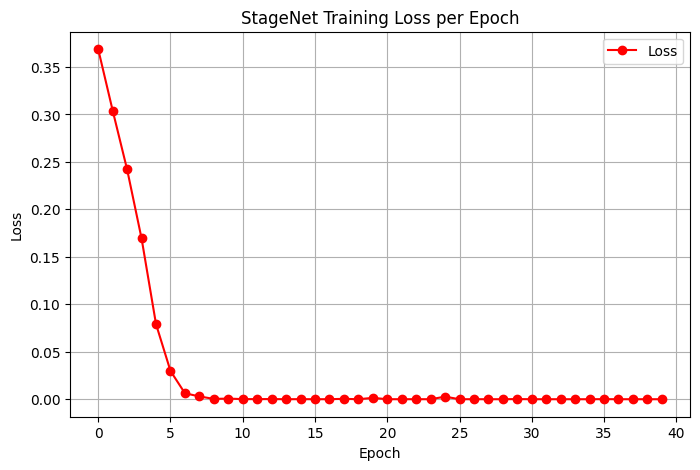

In [19]:
epochs = [metric['epoch'] for metric in trainer.epoch_metrics]
losses = [metric['loss'] for metric in trainer.epoch_metrics if 'loss' in metric]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label='Loss', marker='o', color='r')
plt.title('StageNet Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### TCN Model

An empirical evaluation of Generic RNN for sequence modeling.

The forward function in the class will return the loss, y_prob, y_true just as in RNN Model

In [20]:
from pyhealth.models import TCN

model_TCN = TCN(
    dataset=mimic_sample,
    # get this from mimic_sample.samples[0]
    feature_keys=["conditions","procedures"],
    label_key = "label",
    mode="binary",
)

/opt/anaconda3/envs/DS/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


### Training

For the training 80% train, 10% validation, and 10% test was used.
We will use the pyhealth get_dataloader

In [21]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer

from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.multiclass import multiclass_metrics_fn


train_ds, val_ds, test_ds = split_by_patient(mimic_sample, [0.8,0.1,0.1])

#create data loaders
train_loader = get_dataloader(train_ds, batch_size = 32, shuffle= True)
val_loader = get_dataloader(val_ds, batch_size = 32, shuffle= False)
test_loader = get_dataloader(test_ds, batch_size = 32, shuffle= False)



class CustomTrainer(Trainer):
    def __init__(self, model):
        super().__init__(model=model)
        self.epoch_metrics = []

    def train(self, t_dataloader, v_dataloader, epochs):
        for epoch in range(epochs):
            super().train(train_dataloader=t_dataloader, val_dataloader=v_dataloader, epochs = 1) 
            metrics = self.evaluate(t_dataloader)
            metrics['epoch'] = epoch
            self.epoch_metrics.append(metrics)
    

trainer = CustomTrainer(model=model_TCN)
trainer.train(
    t_dataloader = train_loader,
    v_dataloader = val_loader,
    epochs = 40,
) 


y_true, y_prob, loss = trainer.inference(test_loader)
precision_report.append(binary_metrics_fn(y_true, y_prob, metrics=["precision","roc_auc","f1"]))
accuracy_report.append(multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy","f1_weighted","roc_auc_weighted_ovo"]))


#print(precision_report)
#print(accuracy_report)

TCN(
  (embeddings): ModuleDict(
    (conditions): Embedding(2526, 128, padding_idx=0)
    (procedures): Embedding(815, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (tcn): ModuleDict(
    (conditions): TCNLayer(
      (network): Sequential(
        (0): TemporalBlock(
          (conv1): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (chomp1): Chomp1d()
          (relu1): ReLU()
          (dropout1): Dropout(p=0.5, inplace=False)
          (conv2): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (chomp2): Chomp1d()
          (relu2): ReLU()
          (dropout2): Dropout(p=0.5, inplace=False)
          (net): Sequential(
            (0): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
            (1): Chomp1d()
            (2): ReLU()
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
            (5): Chomp1d()
            (6): ReLU()
    

Epoch 0 / 1: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]

--- Train epoch-0, step-55 ---
loss: 0.4475



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1134
roc_auc: 0.4854
f1: 0.0000
loss: 0.4094



Evaluation: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]

--- Train epoch-0, step-55 ---
loss: 0.3884



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1024
roc_auc: 0.4592
f1: 0.0000
loss: 0.4131



Evaluation: 100%|██████████| 55/55 [00:31<00:00,  1.73it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:51<00:00,  1.08it/s]

--- Train epoch-0, step-55 ---
loss: 0.3529



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1069
roc_auc: 0.4835
f1: 0.0000
loss: 0.4151



Evaluation: 100%|██████████| 55/55 [00:29<00:00,  1.85it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:51<00:00,  1.06it/s]

--- Train epoch-0, step-55 ---
loss: 0.3295



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1121
roc_auc: 0.4956
f1: 0.0000
loss: 0.4236



Evaluation: 100%|██████████| 55/55 [00:28<00:00,  1.92it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]

--- Train epoch-0, step-55 ---
loss: 0.2801



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1115
roc_auc: 0.4969
f1: 0.0000
loss: 0.4586



Evaluation: 100%|██████████| 55/55 [00:35<00:00,  1.54it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]

--- Train epoch-0, step-55 ---
loss: 0.2569



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1116
roc_auc: 0.4929
f1: 0.0000
loss: 0.4704



Evaluation: 100%|██████████| 55/55 [00:53<00:00,  1.03it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:59<00:00,  1.09s/it]

--- Train epoch-0, step-55 ---
loss: 0.2169



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1139
roc_auc: 0.4992
f1: 0.0526
loss: 0.5078



Evaluation: 100%|██████████| 55/55 [00:37<00:00,  1.47it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]

--- Train epoch-0, step-55 ---
loss: 0.1812



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1195
roc_auc: 0.5081
f1: 0.0909
loss: 0.5565



Evaluation: 100%|██████████| 55/55 [00:37<00:00,  1.47it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:02<00:00,  1.14s/it]

--- Train epoch-0, step-55 ---
loss: 0.1509



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1207
roc_auc: 0.4871
f1: 0.0488
loss: 0.6464



Evaluation: 100%|██████████| 55/55 [00:36<00:00,  1.52it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:58<00:00,  1.07s/it]

--- Train epoch-0, step-55 ---
loss: 0.1349



Evaluation: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1243
roc_auc: 0.5154
f1: 0.1277
loss: 0.6378



Evaluation: 100%|██████████| 55/55 [00:36<00:00,  1.53it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:00<00:00,  1.09s/it]

--- Train epoch-0, step-55 ---
loss: 0.0970



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1271
roc_auc: 0.5146
f1: 0.1778
loss: 0.7595



Evaluation: 100%|██████████| 55/55 [00:36<00:00,  1.49it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:02<00:00,  1.14s/it]

--- Train epoch-0, step-55 ---
loss: 0.0885



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1193
roc_auc: 0.5033
f1: 0.0000
loss: 0.8128



Evaluation: 100%|██████████| 55/55 [00:37<00:00,  1.48it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:01<00:00,  1.12s/it]

--- Train epoch-0, step-55 ---
loss: 0.0647



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1253
roc_auc: 0.5225
f1: 0.0976
loss: 0.9483



Evaluation: 100%|██████████| 55/55 [00:38<00:00,  1.44it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]

--- Train epoch-0, step-55 ---
loss: 0.0569



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1264
roc_auc: 0.5108
f1: 0.1224
loss: 1.0104



Evaluation: 100%|██████████| 55/55 [00:38<00:00,  1.41it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:01<00:00,  1.13s/it]

--- Train epoch-0, step-55 ---
loss: 0.0521



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1256
roc_auc: 0.5113
f1: 0.0000
loss: 1.0636



Evaluation: 100%|██████████| 55/55 [00:33<00:00,  1.62it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s]

--- Train epoch-0, step-55 ---
loss: 0.0463



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1253
roc_auc: 0.5144
f1: 0.0851
loss: 1.1247



Evaluation: 100%|██████████| 55/55 [00:32<00:00,  1.70it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:50<00:00,  1.09it/s]

--- Train epoch-0, step-55 ---
loss: 0.0270



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1417
roc_auc: 0.5208
f1: 0.1587
loss: 1.2541



Evaluation: 100%|██████████| 55/55 [00:38<00:00,  1.42it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]

--- Train epoch-0, step-55 ---
loss: 0.0255



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1264
roc_auc: 0.5117
f1: 0.1200
loss: 1.3692



Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]

--- Train epoch-0, step-55 ---
loss: 0.0216



Evaluation: 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1194
roc_auc: 0.4925
f1: 0.1562
loss: 1.5453



Evaluation: 100%|██████████| 55/55 [01:27<00:00,  1.59s/it]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [02:31<00:00,  2.76s/it]

--- Train epoch-0, step-55 ---
loss: 0.0229



Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1147
roc_auc: 0.4769
f1: 0.0455
loss: 1.8499



Evaluation: 100%|██████████| 55/55 [00:31<00:00,  1.77it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]

--- Train epoch-0, step-55 ---
loss: 0.0274



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1166
roc_auc: 0.4835
f1: 0.0851
loss: 1.7375



Evaluation: 100%|██████████| 55/55 [01:02<00:00,  1.13s/it]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:11<00:00,  1.30s/it]

--- Train epoch-0, step-55 ---
loss: 0.0163



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1151
roc_auc: 0.4835
f1: 0.0000
loss: 2.0197



Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.60it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:32<00:00,  1.68s/it]

--- Train epoch-0, step-55 ---
loss: 0.0284



Evaluation: 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1139
roc_auc: 0.4831
f1: 0.0000
loss: 2.1139



Evaluation: 100%|██████████| 55/55 [00:42<00:00,  1.29it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:52<00:00,  1.05it/s]

--- Train epoch-0, step-55 ---
loss: 0.0115



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1207
roc_auc: 0.4958
f1: 0.0000
loss: 2.3946



Evaluation: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [02:28<00:00,  2.70s/it]

--- Train epoch-0, step-55 ---
loss: 0.0106



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1230
roc_auc: 0.4913
f1: 0.1304
loss: 2.2226



Evaluation: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

--- Train epoch-0, step-55 ---
loss: 0.0109



Evaluation: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1139
roc_auc: 0.4792
f1: 0.0526
loss: 2.3425



Evaluation: 100%|██████████| 55/55 [01:49<00:00,  1.99s/it]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:39<00:00,  1.39it/s]

--- Train epoch-0, step-55 ---
loss: 0.0100



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1122
roc_auc: 0.4763
f1: 0.1250
loss: 2.1255



Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.59it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [02:06<00:00,  2.30s/it]

--- Train epoch-0, step-55 ---
loss: 0.0058



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1177
roc_auc: 0.4867
f1: 0.1290
loss: 2.4447



Evaluation: 100%|██████████| 55/55 [00:24<00:00,  2.25it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:40<00:00,  1.35it/s]

--- Train epoch-0, step-55 ---
loss: 0.0106



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1146
roc_auc: 0.4835
f1: 0.0444
loss: 2.6508



Evaluation: 100%|██████████| 55/55 [00:23<00:00,  2.37it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [02:00<00:00,  2.19s/it]

--- Train epoch-0, step-55 ---
loss: 0.0072



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1139
roc_auc: 0.4775
f1: 0.0000
loss: 3.1149



Evaluation: 100%|██████████| 55/55 [00:24<00:00,  2.20it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:38<00:00,  1.42it/s]

--- Train epoch-0, step-55 ---
loss: 0.0119



Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1139
roc_auc: 0.4860
f1: 0.1333
loss: 2.7058



Evaluation: 100%|██████████| 55/55 [00:23<00:00,  2.36it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:51<00:00,  2.04s/it]

--- Train epoch-0, step-55 ---
loss: 0.0068



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1153
roc_auc: 0.4896
f1: 0.0000
loss: 3.5806



Evaluation: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [00:38<00:00,  1.43it/s]

--- Train epoch-0, step-55 ---
loss: 0.0251



Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1187
roc_auc: 0.4908
f1: 0.0000
loss: 3.0354



Evaluation: 100%|██████████| 55/55 [00:22<00:00,  2.45it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:01<00:00,  1.12s/it]

--- Train epoch-0, step-55 ---
loss: 0.0102



Evaluation: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1265
roc_auc: 0.4971
f1: 0.1538
loss: 3.3651



Evaluation: 100%|██████████| 55/55 [00:51<00:00,  1.06it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:26<00:00,  1.56s/it]

--- Train epoch-0, step-55 ---
loss: 0.0106



Evaluation: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1292
roc_auc: 0.5085
f1: 0.1356
loss: 2.9696



Evaluation: 100%|██████████| 55/55 [00:50<00:00,  1.08it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]

--- Train epoch-0, step-55 ---
loss: 0.0015



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1224
roc_auc: 0.4848
f1: 0.0606
loss: 3.8752



Evaluation: 100%|██████████| 55/55 [00:50<00:00,  1.09it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]

--- Train epoch-0, step-55 ---
loss: 0.0094



Evaluation: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1209
roc_auc: 0.4823
f1: 0.0833
loss: 3.2417



Evaluation: 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:26<00:00,  1.57s/it]

--- Train epoch-0, step-55 ---
loss: 0.0007



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1197
roc_auc: 0.4752
f1: 0.0571
loss: 4.2291



Evaluation: 100%|██████████| 55/55 [00:53<00:00,  1.03it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:24<00:00,  1.53s/it]

--- Train epoch-0, step-55 ---
loss: 0.0047



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1188
roc_auc: 0.4652
f1: 0.0000
loss: 4.7202



Evaluation: 100%|██████████| 55/55 [00:51<00:00,  1.06it/s]

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x34e776cf0>
Monitor: None
Monitor criterion: max
Epochs: 1




Epoch 0 / 1: 100%|██████████| 55/55 [01:25<00:00,  1.56s/it]

--- Train epoch-0, step-55 ---
loss: 0.0042



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

--- Eval epoch-0, step-55 ---
pr_auc: 0.1206
roc_auc: 0.4800
f1: 0.1176
loss: 4.4059



Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


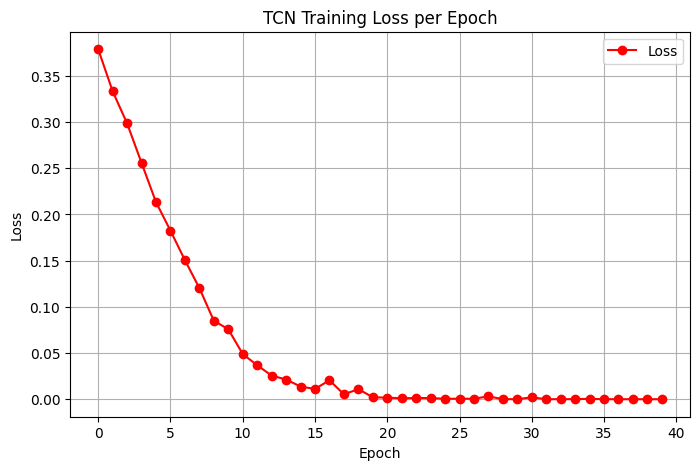

In [35]:
epochs = [metric['epoch'] for metric in trainer.epoch_metrics]
losses = [metric['loss'] for metric in trainer.epoch_metrics if 'loss' in metric]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label='Loss', marker='o', color='r')
plt.title('TCN Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Results

## Model comparison

In [24]:
import pandas as pd

index_names = ['Basic RNN Model', 'RETAIN Model', 'Transformer Model', 'StageNet Model', 'TCN Model']


#df_report = pd.DataFrame(report, index=index_names)
df_precision = pd.DataFrame(precision_report, index=index_names)

df_accuracy = pd.DataFrame(accuracy_report, index=index_names)
# Display the tables
print("\nModel comparison table - Precision:")
print(df_precision)
print("")
print("\nModel comparison table - Accuracy:")
print(df_accuracy)





Model comparison table - Precision:
                   precision   roc_auc        f1
Basic RNN Model     0.333333  0.630376  0.117647
RETAIN Model        0.000000  0.506632  0.000000
Transformer Model   0.222222  0.545995  0.181818
StageNet Model      0.090909  0.543239  0.050000
TCN Model           0.142857  0.550447  0.120000


Model comparison table - Accuracy:
                   accuracy  f1_weighted  roc_auc_weighted_ovo
Basic RNN Model    0.869159     0.808318              0.630376
RETAIN Model       0.864253     0.801322              0.506632
Transformer Model  0.881818     0.826438              0.545995
StageNet Model     0.868182     0.806923              0.543239
TCN Model          0.866972     0.805198              0.550447


# Discussion

### Reproduciblility
I tried to utilize the pyhealth library as much as possible to bencmark various models.

In the research paper it was indicated that the highes average accuracy was obtained by the ODE + RNN model at `0.331`.

Based on testing with Various models indeed Transformer model which closely equates to ODE + RNN presented the highest accuracy.  

In terms of benchmarking the Models Transformer indicated the highest accuracy, however the actual accuracy value differed significantly.  I think this is due to the fact that I excluded some of the csv files in my initial anaysls.


### What was easy/hard

The most obvious easy part was utilizing pyhealth.  PyHealth provided the prediction function as well as all the framework for the model, training and evaluation.



The hardest part was trying to use the recreate the original data using the provided git repository.

After struggling extensively and running out of time, deviated from the original approach and started to look into the pyhealth library.

Despite having numerous limitations, I was able to work up a model comparison scenario based on the Models provided by pyHealth.

An additional struggle I ran into was trying to implement the parsing function to process the unsupported csv files(ICUSTAYS, SERVICES, CARTEVENTS OUTPUTEVENTS).





### Next Phase

I've made an attempt to implement my own parse method.  However was not able to completely implement I am posting the partial code as future work below.

In [33]:
# Parse ICUSTAYS
def parse_icustays(file_path):
    # Load the ICUSTAYS CSV file
    df = pd.read_csv(file_path)

    df.columns = [col.lower() for col in df.columns]

    # Convert date strings to datetime objects
    df['intime'] = pd.to_datetime(df['intime'], errors='coerce')
    df['outtime'] = pd.to_datetime(df['outtime'], errors='coerce')

    df['los_hours'] = df['los'] * 24

    # Add any additional processing needed here

    return df

# References

1.   Sebastiano Barbieri1, James Kemp1, Oscar Perez-Concha, Sradha Kotwal,Martin Gallagher, Angus Ritchie & Louisa Jorm, Benchmarking Deep Learning Architectures for Predicting Readmission to the ICU and Describing Patients-at-Risk, Scientific Reports, 2020, Article number: 1111, https://doi.org/10.1038/s41598-020-58053-z

2.   Alistair E.W. Johnson, Tom J. Pollard, Lu Shen, Li-wei H. Lehman, Mengling Feng, Mohammad Ghassemi, Benjamin Moody, Peter Szolovits, Leo Anthony Celi & Roger G. Mark , MIMIC-III, a freely accessible critical care database, Scientific Data, 2016,  Article number: 160035, https://www.nature.com/articles/sdata201635

3. Johnson, A., Pollard, T., & Mark, R. (2019). MIMIC-III Clinical Database Demo (version 1.4). PhysioNet. https://physionet.org/content/mimiciii-demo/1.4/

4. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Attention Is All You Need, NIPS 2017 ,https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

5. Edward Choi, Mohammad Taha Bahadori, Joshua A. Kulas, Andy Schuetz, Walter F. Stewart, Jimeng Sun, RETAIN: An Interpretable Predictive Model for Healthcare using Reverse Time Attention Mechanism,  (NIPS) 2016,  https://arxiv.org/abs/1608.05745

6. Jin Jing, Wendong Ge, Shenda Hong, Marta Bento Fernandes, Zhen Lin, Chaoqi Yang , Sungtae An, Aaron F Struck, Aline Herlopian, Ioannis Karakis, Jonathan J Halford, Marcus C Ng, Emily L Johnson, Brian L Appavu, Rani A Sarkis, Gamaleldin Osman, Peter W Kaplan, Monica B Dhakar, Lakshman Arcot Jayagopal, Zubeda Sheikh, Olga Taraschenko, Sarah Schmitt, Hiba A Haider, Jennifer A Kim, Christa B Swisher, Nicolas Gaspard, Mackenzie C Cervenka  , Andres A Rodriguez Ruiz, Jong Woo Lee, Mohammad Tabaeizadeh, Emily J Gilmore, Kristy Nordstrom, Ji Yeoun Yoo, Manisha G Holmes, Susan T Herman, Jennifer A Williams, Jay Pathmanathan, Fábio A Nascimento, Ziwei Fan, Samaneh Nasiri, Mouhsin M Shafi, Sydney S Cash, Daniel B Hoch, Andrew J Cole  , Eric S Rosenthal, Sahar F Zafar, Jimeng Sun, M Brandon Westover, Development of Expert-Level Classification of Seizures and Rhythmic and Periodic Patterns During EEG Interpretation, Neurology. 2023 Apr 25;100(17):e1750-e1762.  doi: 10.1212/WNL.0000000000207127. Epub 2023 Mar 6., https://pubmed.ncbi.nlm.nih.gov/36878708/

7. Shaojie Bai, J. Zico Kolter, Vladlen Koltun, An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling, arXiv:1803.01271 v2 April 2018, https://arxiv.org/abs/1803.01271


- GitHub Links

  https://github.com/sunlabuiuc/PyHealth
  
  https://github.com/sebbarb/time_aware_attention/blob/master/README.md

  https://github.com/MIT-LCP/mimic-website

  https://github.com/MIT-LCP/mimic-iii-paper/

  https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii


  

  https://github.com/rtqichen/torchdiffeq
